# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import pdb

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

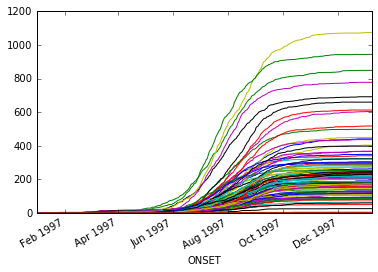

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [9]:
total_district_cases = measles_onset_dist.sum()

Top 5 districts by number of cases

In [10]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

Age distribution of cases, by confirmation status

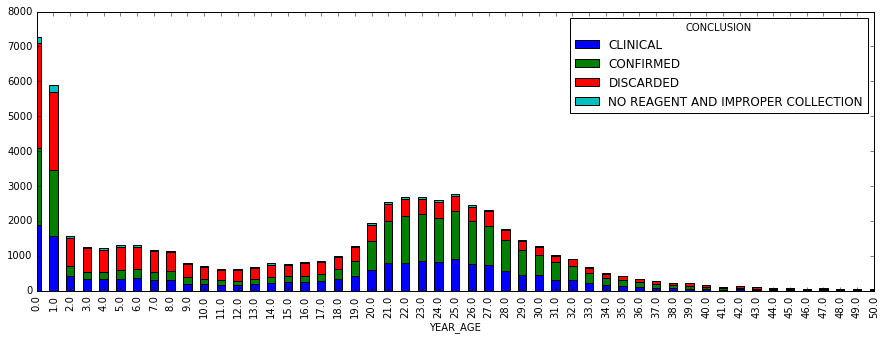

In [11]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

## Stochastic Disease Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple SIR disease model, which will be fit using MCMC.

This model fits the series of 2-week infection totals in each district $i$ as a set of Poisson models:

\\[Pr(I(t)_{i} | \lambda(t)_i) = \text{Poisson}(\lambda(t)_i) \\]

Where the outbreak intensity is modeled as:

\\[\lambda(t)_i = \beta [I^{(w)}(t-1)_i]^{\alpha} S(t-1)_i\\]

\\[\alpha \sim \text{Exp}(1)\\]

We will assume here that the transmission rate is constant over time (and across districts):

\\[\beta \sim \text{Gamma}(1, 0.1)\\]

To account for the influence of infected individuals from neighboring districts on new infections, the outbreak intensity was modeled using a spatial-weighted average of infecteds across districts, where populations were weighted as an exponential function of the distance between district centroids:

\\[w_{d} = \text{exp}(-\theta d)\\]

\\[\theta \sim \text{Exp}(1)\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. These estimates are then plugged into the model in place of the clinically-confirmed cases.

We specified a structured confirmation model to retrospectively determine the age group-specific probabilities of lab confirmation for measles, conditional on clinical diagnosis. Individual lab confirmation events $c_i$ were modeled as Bernoulli random variables, with the probability of confirmation being allowed to vary by age group:

$$c_i \sim \text{Bernoulli}(p_{a(i)})$$

where $a(i)$ denotes the appropriate age group for the individual indexed by i. There were 16 age groups, the first 15 of which were 5-year age intervals $[0,5), [5, 10), \ldots , [70, 75)$, with the 16th interval including all individuals 75 years and older.

Since the age interval choices were arbitrary, and the confirmation probabilities of adjacent groups likely correlated, we modeled the correlation structure directly, using a multivariate logit-normal model. Specifically, we allowed first-order autocorrelation among the age groups, whereby the variance-covariance matrix retained a tridiagonal structure. 

$$\begin{aligned}
\Sigma = \left[{
\begin{array}{c}
  {\sigma^2} & {\sigma^2 \rho} & 0& \ldots & {0} & {0}  \\
  {\sigma^2 \rho} & {\sigma^2} &  \sigma^2 \rho & \ldots & {0}  & {0} \\
  {0} & \sigma^2 \rho & {\sigma^2} & \ldots & {0} & {0} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {0} & {0} & 0 & \ldots &  {\sigma^2} & \sigma^2 \rho  \\
{0} & {0} & 0 & \ldots & \sigma^2 \rho &  {\sigma^2} 
\end{array}
}\right]
\end{aligned}$$

From this, the confirmation probabilities were specified as multivariate normal on the inverse-logit scale.

$$ \text{logit}(p_a) = \{a\} \sim N(\mu, \Sigma)$$

Priors for the confirmation sub-model were specified by:

$$\begin{aligned}
\mu_i &\sim N(0, 100) \\
\sigma &\sim \text{HalfCauchy}(25) \\
\rho &\sim U(-1, 1)
\end{aligned}$$

Age classes are defined in 5-year intervals.

In [12]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [13]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract confirmed and clinical subset, with no missing county information.

In [14]:
lab_subset = measles_data[(CONFIRMED | CLINICAL) & measles_data.COUNTY.notnull()].copy()

In [15]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

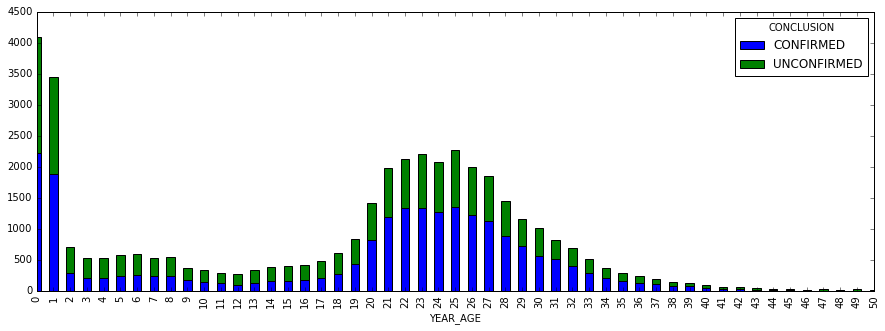

In [16]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [17]:
lab_subset.shape

(39982, 16)

In [18]:
y.sum()

22097

Proportion of lab-confirmed cases older than 20 years

In [19]:
(measles_data[CONFIRMED].YEAR_AGE>20).mean()

0.60257048468117846

In [20]:
age_classes

[0, 5, 10, 15, 20, 25, 30, 35, 40, 100]

In [21]:
#Extract cases by age and time.

age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])

In [22]:
age_group.categories

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [23]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [24]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [25]:
excludes = ['BOM RETIRO']

In [26]:
N = sp_pop.ix[unique_districts, 'Total'].dropna()
N = N.drop(excludes).sum()
N

9727688.0

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [27]:
sp_counts_2w = lab_subset.groupby(
    ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')

# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = confirmed_data.groupby(
    ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).sum()

all_confirmed_cases = confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique()).fillna(0)

In [28]:
# Ensure the age groups are ordered
I_obs = sp_counts_2w.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int)

In [29]:
I_obs.max()

1442

In [30]:
I_obs.sum()

38502

In [31]:
age_groups = np.sort(measles_data['AGE_GROUP'].unique())
age_groups

array(['[0, 5)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)', '[5, 10)'], dtype=object)

Check shape of data frame

- 28 bi-monthly intervals, 9 age groups

In [32]:
assert I_obs.shape == (28, len(age_groups))

Prior distribution on susceptible proportion:

$$p_s \sim \text{Beta}(2, 100)$$

(array([  3.19500000e+03,   3.50600000e+03,   1.87800000e+03,
          8.58000000e+02,   3.66000000e+02,   1.35000000e+02,
          4.10000000e+01,   1.50000000e+01,   3.00000000e+00,
          3.00000000e+00]),
 array([ 0.00016084,  0.01135736,  0.02255387,  0.03375039,  0.0449469 ,
         0.05614342,  0.06733993,  0.07853645,  0.08973296,  0.10092948,
         0.11212599]),
 <a list of 10 Patch objects>)

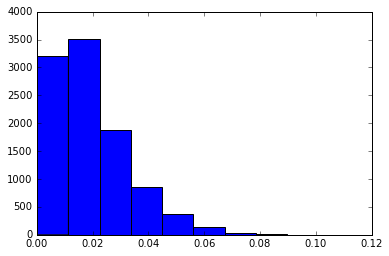

In [33]:
from pymc import rbeta
plt.hist(rbeta(2, 100, 10000))

In [34]:
I_obs

array([[   1,    3,    0,    1,    0,    0,    0,    0,    1],
       [   4,   13,    7,   18,    1,    2,    0,    1,    4],
       [   3,   12,    2,   14,    0,    1,    1,    2,    5],
       [   4,   10,    2,   17,    0,    2,    2,    2,    2],
       [   6,   15,    7,   19,    1,    3,    1,    7,    6],
       [  19,   27,   20,   34,    0,    7,    2,   13,    8],
       [   9,   27,    6,   26,    1,    1,    1,    6,    8],
       [  13,   27,   13,   20,    1,    4,    2,    5,    2],
       [  28,   32,   16,   21,    2,    6,    1,    9,    9],
       [  42,   39,   46,   31,    6,   17,    2,   13,   18],
       [  93,   69,   72,   40,    4,   18,    6,   19,   26],
       [ 157,   95,  153,   64,   12,   47,    5,   31,   42],
       [ 359,  183,  315,  169,   26,   95,   18,   76,   68],
       [ 807,  363,  622,  282,   65,  234,   34,  162,  136],
       [1168,  660, 1035,  388,   87,  398,   63,  257,  166],
       [1442,  913, 1193,  536,  137,  430,   48,  318,

In [35]:
obs_date = '1997-06-15'
obs_index = sp_counts_2w.index <= obs_date
I_obs_t = I_obs[obs_index]

In [36]:
np.sum(I_obs_t, (0)) / float(I_obs_t.sum())

array([ 0.21114206,  0.20557103,  0.19164345,  0.16991643,  0.01559889,
        0.06016713,  0.01281337,  0.06016713,  0.0729805 ])

In [37]:
I_obs_t

array([[  1,   3,   0,   1,   0,   0,   0,   0,   1],
       [  4,  13,   7,  18,   1,   2,   0,   1,   4],
       [  3,  12,   2,  14,   0,   1,   1,   2,   5],
       [  4,  10,   2,  17,   0,   2,   2,   2,   2],
       [  6,  15,   7,  19,   1,   3,   1,   7,   6],
       [ 19,  27,  20,  34,   0,   7,   2,  13,   8],
       [  9,  27,   6,  26,   1,   1,   1,   6,   8],
       [ 13,  27,  13,  20,   1,   4,   2,   5,   2],
       [ 28,  32,  16,  21,   2,   6,   1,   9,   9],
       [ 42,  39,  46,  31,   6,  17,   2,  13,  18],
       [ 93,  69,  72,  40,   4,  18,   6,  19,  26],
       [157,  95, 153,  64,  12,  47,   5,  31,  42]])

In [38]:
I_obs_t.sum((0,1))

1795

In [39]:
tt.fill?

Object `tt.fill` not found.


In [40]:
I_obs_t.sum(1).shape

(12,)

In [42]:
from pymc3 import *
import theano.tensor as tt
from theano.tensor.nlinalg import matrix_inverse as inv

def invlogit(x):
    return 1 / (1 + tt.exp(-x))

def measles_model(obs_date, confirmation=True):
    
    with Model() as model:
    
        n_periods, n_age_groups = I_obs.shape

        ### Confirmation sub-model

        if confirmation:

            # Specify priors on age-specific means
            age_classes = np.unique(age_index)

            mu = Normal("mu", mu=0, tau=0.0001, shape=n_age_groups)
            sig = HalfCauchy('sig', 25, shape=n_age_groups)
#             var = sig**2
#             cor = Uniform('cor', -1, 1)

            # Build variance-covariance matrix with first-order correlation 
            # among age classes
#             Sigma = (tt.eye(len(age_classes))*sig 
#                      + tt.eye(len(age_classes), k=1)*cor 
#                      + tt.eye(len(age_classes), k=-1)*cor)
            Sigma = tt.diag(tt.pow(sig,-2))

            # Age-specific probabilities of confirmation as multivariate normal 
            # random variables
            beta_age = MvNormal("beta_age", mu=mu, tau=Sigma, 
                                shape=n_age_groups)
            p_age = invlogit(beta_age)

            p_confirm = invlogit(beta_age[age_index])


            # Confirmation likelihood
            lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, observed=y)


        '''
        Truncate data at observation period
        '''
        obs_index = sp_counts_2w.index <= obs_date
        I_obs_t = I_obs[obs_index]  


        # Index for observation date, used to index out values of interest 
        # from the model.
        t_obs = obs_index.sum() - 1

        if confirmation:

            I_age = [Binomial('I_age_%i' % n, i, p_age, shape=n_age_groups) 
                         for n,i in enumerate(I_obs_t)]
            I = tt.stacklists(I_age)

        else:

            I = I_obs_t


        # Calcuate age distribution from observed distribution of infecteds to date
        age_dist = Dirichlet('_age_dist', np.ones(n_age_groups), 
                             shape=n_age_groups, 
                             testval=I_obs_t.sum(0)/I_obs_t.sum())
        
        age_dist_like = Potential('age_dist_like', 
                            Multinomial.dist(I.sum(), age_dist).logp(I.sum(0)))


        # Weakly-informative prior on proportion susceptible being 
        # between 0 and 0.07
        p_susceptible = Beta('p_susceptible', 2, 100, testval=0.04)

        # Estimated total initial susceptibles
        S_0 = Binomial('S_0', n=int(N), p=p_susceptible)

        S = S_0 - I.sum(1).cumsum()

        # Susceptibles at time t, by age
        S_age = Multinomial('S_age', S[-1], age_dist, shape=n_age_groups)

        # Transmission parameter
        beta = Uniform('beta', 1, 50, testval=30)         


        # Force of infection
        lam = beta * I.sum(1) * S / N
        
        new_cases = Potential('new_cases', Poisson.dist(lam[:-1]).logp(I.sum(1)[1:]))


    return model

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

June 15, with lab confirmation

In [43]:
model = measles_model('1997-06-15')

In [44]:
with model:
    
    steps = Metropolis(vars=model.disc_vars), NUTS(vars=model.cont_vars)
    
    trace = sample(2000, step=steps)

/usr/local/lib/python3.4/site-packages/theano/tensor/opt.py:4173: UserWarning: Your current code is fine, but Theano versions prior to 0.7 (or this development version Sept 2014) might have given an incorrect result for this code. To disable this warning, set the Theano flag warn.reduce_join to False. The problem was an optimization, that modified the pattern "Reduce{scalar.op}(Join(axis=0, a, b), axis=0)", did not check the reduction axis. So if the reduction axis was not 0, you got a wrong answer.
  'Your current code is fine, but Theano versions '
/usr/local/lib/python3.4/site-packages/theano/tensor/opt.py:4173: UserWarning: Your current code is fine, but Theano versions prior to 0.7 (or this development version Sept 2014) might have given an incorrect result for this code. To disable this warning, set the Theano flag warn.reduce_join to False. The problem was an optimization, that modified the pattern "Reduce{scalar.op}(Join(axis=0, a, b), axis=0)", did not check the reduction axis

 [-----------------100%-----------------] 2001 of 2000 complete in 3158.6 sec

/usr/local/Cellar/python3/3.4.3_2/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


July 15, with lab confirmation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b9e4128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12bc8e0b8>]], dtype=object)

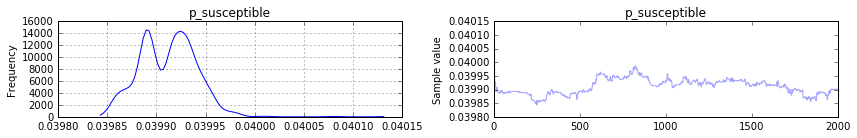

In [45]:
traceplot(trace, vars=['p_susceptible'])

In [ ]:
model_july = MCMC(model('1997-07-15'), db=db, dbname='model_july')
# model_july.use_step_method(AdaptiveMetropolis, model_july.age_dist)
# model_july.use_step_method(AdaptiveMetropolis, [model_july.beta, model_july.p_susceptible])

In [ ]:
model_july.sample(n_iterations, n_burn)

June 15, no lab confirmation

In [ ]:
model_june_noconf = MCMC(model('1997-06-15', 
                                       confirmation=False), 
                         db=db, dbname='model_june_noconf')
model_june_noconf.use_step_method(AdaptiveMetropolis, [model_june_noconf.β, model_june_noconf.p_susceptible])
model_june_noconf.use_step_method(AdaptiveMetropolis, model_june_noconf.age_dist)

In [ ]:
model_june_noconf.sample(n_iterations, n_burn)

July 15, no lab confirmation

In [ ]:
model_july_noconf = MCMC(model('1997-07-15', 
                                       confirmation=False), 
                         db=db, dbname='model_july_noconf')
model_july_noconf.use_step_method(AdaptiveMetropolis, [model_july_noconf.β, model_july_noconf.p_susceptible])
model_july_noconf.use_step_method(AdaptiveMetropolis, model_july_noconf.age_dist)

In [ ]:
model_july_noconf.sample(n_iterations, n_burn)

## Summary of model output

Distance weighting parameter for june model with confirmation

In [ ]:
Matplot.plot(model_june.p_susceptible)

In [ ]:
Matplot.plot(model_june.theta)

Lab confirmation rates, June model

In [ ]:
import seaborn as sb

p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

f, axes = plt.subplots(figsize=(14,6))
sb.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
          color=sb.color_palette("coolwarm", 5)[0],
          order=age_group.categories)
axes.set_ylabel('Confirmation rate')
axes.set_xlabel('Age group')

Proportion of population susceptible, June model.

In [ ]:
Matplot.plot(model_july.β)

Proportion of population susceptible, June model with no confirmation correction

In [ ]:
Matplot.plot(model_june_noconf.p_susceptible)

Epidemic intensity estimates at June and July, per district.

In [ ]:
Matplot.summary_plot(model_june.λ_t)

In [ ]:
Matplot.summary_plot(model_july.λ_t)

Epidemic intensity for lab- versus clinical-confirmation models

In [ ]:
lam_june = model_june.λ.stats()

fig, axes = plt.subplots(2, 1, sharey=True)

axes[0].plot(lam_june['quantiles'][50].T, 'b-', alpha=0.4)
axes[0].set_ylabel('Epidemic intensity')
axes[0].set_xlabel('time (2-week periods)')
axes[0].set_title('Lab confirmation')

lam_june_noconf = model_june_noconf.λ.stats()

axes[1].plot(lam_june_noconf['quantiles'][50].T, 'b-', alpha=0.4)
axes[1].set_ylabel('Epidemic intensity')
axes[1].set_xlabel('time (2-week periods)')
axes[1].set_title('Clinical confirmation')


In [ ]:
S_age_june = pd.DataFrame(model_june.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

In [ ]:
S_age_june = pd.DataFrame(model_june.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)

In [ ]:
S_age_july = pd.DataFrame(model_july.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace()[:, -1], columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)

Numbers of suscepibles in each age group, under lab vs clinical confirmation

In [ ]:
import seaborn as sb
sb.set_context("talk", font_scale=0.8)
sb.set_style("white")

g = sb.factorplot("Age", "S", "Confirmation", S_age_june, kind="box",
                   palette="hls", size=6, aspect=2, linewidth=0.3, fliersize=0, 
                  order=age_group.categories)
g.despine(offset=10, trim=True)
g.set_axis_labels("Age Group", "Susceptibles");

In [ ]:
june_lam = pd.DataFrame(model_june.λ_t.trace()).unstack().reset_index()
june_lam.columns = ('district', 'iteration', 'λ')
june_lam['month'] = 'June'

In [ ]:
june_lam_noconf = pd.DataFrame(model_june_noconf.λ_t.trace()).unstack().reset_index()
june_lam_noconf.columns = ('district', 'iteration', 'λ')
june_lam_noconf['month'] = 'June'

In [ ]:
july_lam = pd.DataFrame(model_july.λ_t.trace()).unstack().reset_index()
july_lam.columns = ('district', 'iteration', 'λ')
july_lam['month'] = 'July'

In [ ]:
model_july.S.value.min()

In [ ]:
july_lam_noconf = pd.DataFrame(model_july_noconf.λ_t.trace()).unstack().reset_index()
july_lam_noconf.columns = ('district', 'iteration', 'λ')
july_lam_noconf['month'] = 'July'

In [ ]:
confirmed_lam = june_lam.append(july_lam, ignore_index=True)

In [ ]:
june_means = june_lam.groupby('district')['λ'].mean()
june_means.sort(ascending=False)

In [ ]:
july_means = july_lam.groupby('district')['λ'].mean()
july_means.sort(ascending=False)

In [ ]:
sorted_districts = june_means.index.values

Epidemic intensity by district in June and July (with lab confirmation), sorted by June means.

In [ ]:
sb.set_context("talk", font_scale=0.8)

f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=june_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('June')
ax_1.set_title(r'Epidemic intensity (λ) estimates, ordered by June means')

sb.boxplot('district', 'λ', data=july_lam, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_2.set_xticks([])
ax_2.set_ylabel('July')

f.tight_layout()

Epidemic intensity by district in June for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

In [ ]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=june_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
ax_1.set_title(r'June epidemic intensity (λ) estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'λ', data=june_lam_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

Epidemic intensity by district in July for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

In [ ]:
july_means = july_lam.groupby('district')['λ'].mean()
july_means.sort(ascending=False)

In [ ]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=july_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=july_means.index.values)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
# ax_1.set_yticks(np.arange(13, step=2))
ax_1.set_title(r'July epidemic intensity (λ) estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'λ', data=july_lam_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

In [ ]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

In [ ]:
june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [ ]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

In [ ]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

In [ ]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

In [ ]:
axes = sb.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sb.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sb.despine(offset=10, trim=True)

In [ ]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
Matplot.summary_plot(model_june.p_age)

## Mapping spatial effects

In [ ]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

lllat=-24
urlat=-23.3
lllon=-47
urlon=-46.3

SP_base = Basemap(ax=None, lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, 
                  resolution='i',
                 epsg='4326')

In [ ]:
SP_dist = gpd.GeoDataFrame.from_file('Sao Paulo/Brazil_full/BRA_adm3.shp').to_crs({'proj': 'longlat', 
                                                                               'ellps': 'WGS84', 
                                                                               'datum': 'WGS84'})

In [ ]:
SP_dist['DIST_NAME'] = [trans.trans(_).upper() for _ in SP_dist.NAME_3]

In [ ]:
λ_june = pd.Series(model_june.λ_t.stats()['mean'], index=sp_districts)

In [ ]:
λ_june

In [ ]:
SP_dist_merged = SP_dist.merge(pd.DataFrame(λ_june, columns=['λ']), left_on='DIST_NAME', right_index=True)

In [ ]:
measles_onset_conf = measles_data[CONFIRMED].groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0).sum()

In [ ]:
measles_onset_conf

In [ ]:
_rates = measles_onset_conf/sp_pop.sum(1)

In [ ]:
SP_dist_conf = SP_dist.merge(pd.DataFrame(_rates, columns=['rate']), left_on='DIST_NAME', right_index=True)

Estimated expected value for infecteds, by district

In [ ]:
from matplotlib.pyplot import cm

map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist_merged.plot(column='λ', colormap=cm.Reds, axes=map_ax)

Observed confirmed cases, by district

In [ ]:
map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist_conf.plot(column='rate', colormap=cm.Reds, axes=map_ax)